In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
%ls

 Basic_LSTM1.ipynb
 Basic_LSTM2.ipynb
'Basic LSTM.ipynb'
 checkpoint
 CHRIS-MGEX_MW5.csv
 IntRates.csv
 multivariate_ts_pollution_case.data-00000-of-00001
 multivariate_ts_pollution_case.index
 multivariate_ts_pollution_case.meta
 quotes.csv
 Seq2seq_Model.ipynb
 SP500.csv
 Stock-Prediction-using-LSTM-master/
 АБ1.gdoc


In [ ]:
%cd drive/My\ Drive/AI\ investing\ /

[Errno 2] No such file or directory: 'drive/My Drive/AI investing /'
/content/drive/My Drive/AI investing 


In [ ]:
df = pd.read_csv("SP500.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [ ]:
df.drop(["Open","High","Low","Adj Close","Volume"], axis = 1, inplace = True)

In [ ]:
df.head(3)

,Date,Close
0,2000-01-03,1455.219971
1,2000-01-04,1399.420044
2,2000-01-05,1402.109985


In [ ]:
df.set_index('Date', inplace = True)

In [ ]:
IR_df = pd.read_csv("IntRates.csv")

In [ ]:
IR_df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,6.498,6.603,6.498,6.548,6.548,0.0
1,2000-01-04,6.530,6.548,6.485,6.485,6.485,0.0
2,2000-01-05,6.521,6.599,6.508,6.599,6.599,0.0


In [ ]:
IR_df.drop(["Open","High","Low","Adj Close","Volume"], axis = 1, inplace = True)

In [ ]:
IR_df.dropna(axis=0, inplace = True)

In [ ]:
IR_df.set_index("Date", inplace = True)

In [ ]:
IR_df['INT_RT'] = IR_df['Close']
IR_df.drop(['Close'], axis = 1, inplace = True)

In [ ]:
df = df.join(IR_df)

In [ ]:
for i in range(len(df)):
    if np.isnan(df['INT_RT'].iloc[i]):
        df['INT_RT'].iloc[i] = (df['INT_RT'].iloc[i+1] + df['INT_RT'].iloc[i-1])/2

In [ ]:
df["DV_INT_RT"] = np.gradient(df['INT_RT'])

In [ ]:
df.drop(['INT_RT'], axis=1, inplace=True)

In [ ]:
df.head()

,Close,DV_INT_RT
Date,,
2000-01-03,1455.219971,-0.0630
2000-01-04,1399.420044,0.0255
2000-01-05,1402.109985,0.0320
2000-01-06,1403.449951,-0.0475
2000-01-07,1441.469971,0.0045


In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
 
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, target, n_in=1, n_out=1, dropnan=True, n_targets=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    print("TARGET: ", target)
    print(df)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[target].shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_targets)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_targets)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    print(agg)
    return agg
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        a = i - interval
        value = dataset[i] - dataset[a]
        diff.append(value)
    return Series(diff)

def other_concat(dataset, interval=1):
    diff = list()
    for i in range(len(dataset)):
        diff.append(value)
    return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_targets, target, n_test, n_lag, n_seq, ncol=1):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series_target = difference(raw_values[:,0], 1)
    diff_values_target = diff_series_target.values
    diff_values_target = diff_values_target.reshape(len(diff_values_target), 1)
    print(ncol)
    diff_df = pd.concat([difference(raw_values[:, i], 1) for i in range(0,ncol)], axis=1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_df)
    special_scaler = MinMaxScaler(feature_range=(-1, 1))
    special_values = special_scaler.fit_transform(diff_values_target)
    print("Scaled_VAL1: ",scaled_values)
    #scaled_values = scaled_values.reshape(int(len(scaled_values)*ncol), 1)
    print("Scaled_VAL2: ",scaled_values)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, target-1, n_lag, n_seq, True, 1)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return special_scaler, train, test
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model
  
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:-n_seq], test[i, -n_seq:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [ ]:
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = df
# configure
n_lag = 30
n_seq = 7
n_test = 300
n_epochs = 10
n_batch = 1
n_neurons = 100
n_col=2
target=1
# prepare data
scaler, train, test = prepare_data(series, 1, target, n_test, n_lag, n_seq, n_col)
# fit model

2
Scaled_VAL1:  [[-0.03077752  0.37911025]
 [ 0.17989419  0.06189555]
 [ 0.17503178 -0.27079304]
 ...
 [-0.09888862  0.05609284]
 [ 0.32937095  0.14313346]
 [ 0.33967262  0.0696325 ]]
Scaled_VAL2:  [[-0.03077752  0.37911025]
 [ 0.17989419  0.06189555]
 [ 0.17503178 -0.27079304]
 ...
 [-0.09888862  0.05609284]
 [ 0.32937095  0.14313346]
 [ 0.33967262  0.0696325 ]]
TARGET:  0
             0         1
0    -0.030778  0.379110
1     0.179894  0.061896
2     0.175032 -0.270793
3     0.307148  0.237911
4     0.228303  0.328820
...        ...       ...
5150 -0.121400  0.007737
5151  0.290615  0.011605
5152 -0.098889  0.056093
5153  0.329371  0.143133
5154  0.339673  0.069632

[5155 rows x 2 columns]
      var1(t-30)  var2(t-30)  var1(t-29)  ...  var1(t+4)  var1(t+5)  var1(t+6)
30     -0.030778    0.379110    0.179894  ...   0.200893   0.144056   0.097916
31      0.179894    0.061896    0.175032  ...   0.144056   0.097916   0.223117
32      0.175032   -0.270793    0.307148  ...   0.097916   0.

In [ ]:
train[:, 0:-n_seq]

array([[-0.03077752,  0.01496259,  0.17989419, ..., -0.03241895,
         0.21382421,  0.20448878],
       [ 0.17989419,  0.4563591 ,  0.17503178, ...,  0.20448878,
         0.11841081,  0.159601  ],
       [ 0.17503178,  0.04738155,  0.30714782, ...,  0.159601  ,
         0.17233039,  0.22693267],
       ...,
       [ 0.15882301,  0.17206983,  0.10465194, ...,  0.3117207 ,
         0.16361464,  0.15461347],
       [ 0.10465194,  0.09725686,  0.0890917 , ...,  0.15461347,
         0.17553609,  0.26932668],
       [ 0.0890917 ,  0.03241895,  0.14909907, ...,  0.26932668,
         0.14639681,  0.17206983]])

In [ ]:
# reshape training into [samples, timesteps, features]
X, y = train[:, 0:-n_seq], train[:, -n_seq:]
X = X.reshape(X.shape[0], 1, X.shape[1])

print(X.shape)
X_test, y_test = test[:, 0:-n_seq], test[:, -n_seq:]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(y)

(4819, 1, 60)
[[0.11841081 0.17233039 0.01831526 ... 0.20089281 0.1440564  0.09791605]
 [0.17233039 0.01831526 0.19210495 ... 0.1440564  0.09791605 0.22311682]
 [0.01831526 0.19210495 0.20089281 ... 0.09791605 0.22311682 0.23637138]
 ...
 [0.20625997 0.17060201 0.23896417 ... 0.17553609 0.14639681 0.18670217]
 [0.17060201 0.23896417 0.16361464 ... 0.14639681 0.18670217 0.18079465]
 [0.23896417 0.16361464 0.17553609 ... 0.18670217 0.18079465 0.26280884]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Conv1D
import tensorflow as tf

In [ ]:
with tf.device('/device:GPU:0'):
    # define model
    model = Sequential()
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2])))
    model.add(tf.keras.layers.Activation('tanh'))
    model.add(tf.keras.layers.Dropout(0.2))
#model = Sequential()
#model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (1, 100)                  64800     
_________________________________________________________________
activation_3 (Activation)    (1, 100)                  0         
_________________________________________________________________
dropout_3 (Dropout)          (1, 100)                  0         
_________________________________________________________________
dense_3 (Dense)              (1, 7)                    707       
Total params: 65,507
Trainable params: 65,507
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X, y, validation_data=(X_test, y_test), epochs=n_epochs, batch_size=n_batch, shuffle=False)

Epoch 1/10
4819/4819 [==============================] - 15s 3ms/step - loss: 0.0037 - val_loss: 0.0373
Epoch 2/10
4819/4819 [==============================] - 15s 3ms/step - loss: 0.0034 - val_loss: 0.0372
Epoch 3/10
4819/4819 [==============================] - 15s 3ms/step - loss: 0.0033 - val_loss: 0.0372
Epoch 4/10
4819/4819 [==============================] - 16s 3ms/step - loss: 0.0033 - val_loss: 0.0378
Epoch 5/10
4819/4819 [==============================] - 15s 3ms/step - loss: 0.0033 - val_loss: 0.0388
Epoch 6/10
 956/4819 [====>.........................] - ETA: 11s - loss: 0.0031

KeyboardInterrupt: ignored

In [ ]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

In [ ]:
forecasts = inverse_transform(series['Close'], forecasts, scaler, n_test+2)
actual = [row[-n_seq:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

In [ ]:
np.asarray(forecasts)

array([[2902.97251743, 2903.43569082, 2905.78571457, ..., 2906.75904623,
        2908.25263944, 2908.75104013],
       [2909.05764168, 2910.85195142, 2911.1193786 , ..., 2912.97775295,
        2914.08919111, 2915.11571148],
       [2934.74638355, 2934.73697762, 2934.59653778, ..., 2937.13583083,
        2938.68060393, 2938.39822481],
       ...,
       [3132.19725823, 3131.81927934, 3129.85320142, ..., 3132.96802523,
        3134.60434797, 3133.84206691],
       [3048.52197885, 3047.26891529, 3047.45975673, ..., 3050.48506224,
        3050.19284099, 3048.9574303 ],
       [3083.65955095, 3083.4000044 , 3084.50456263, ..., 3085.96144516,
        3085.82250708, 3088.16506332]])

In [ ]:
int(len(forecasts)/10)

30

In [ ]:
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    #for j in range(int(len(series.tail(300)))):
    plt.figure(figsize=(15,10))
    off_s = len(series) - n_test + 2 + 0 - 1
    print("OFF_S: ", off_s)
    off_e = len(series)
    print("OFF_E: ", off_e)
    xaxis = [x for x in range(off_s, off_e)]
    xaxis = xaxis[:-1]
    #print("XAXIS: ", xaxis)
    yaxis = np.asarray(series.tail(300).values).reshape(-1)
    #print("YAXIS: ", yaxis)
    pyplot.plot(xaxis, yaxis, color='blue')
    # plot the forecasts in red
    for i in range(int(len(forecasts)/10)):
        off_s = len(series) - n_test + i*10 - 1
        print("OFF_S: ", off_s)
        off_e = off_s + len(forecasts[i*10]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i*10]
        print("XAXIS: ", xaxis)
        print("YAXIS: ", np.asarray(yaxis))
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

OFF_S:  4855
OFF_E:  5156
OFF_S:  4853
XAXIS:  [4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860]
YAXIS:  [array([2905.030029]) 2902.9725174319306 2903.4356908213654
 2905.785714567856 2906.211707980589 2906.759046227888 2908.2526394438305
 2908.751040132002]
OFF_S:  4863
XAXIS:  [4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870]
YAXIS:  [array([2945.639893]) 2944.631248419159 2946.445287887924
 2946.6425624983244 2947.585220028632 2947.6496197106176
 2949.6205623270803 2951.219998729401]
OFF_S:  4873
XAXIS:  [4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880]
YAXIS:  [array([2859.530029]) 2863.937652767853 2866.608524025635
 2867.6348499667206 2868.2287387263336 2869.764141381935
 2873.0166538369217 2875.016944946007]
OFF_S:  4883
XAXIS:  [4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890]
YAXIS:  [array([2744.449951]) 2746.165962285782 2746.7524828980218
 2748.400799042965 2750.930004126812 2755.0315585205803 2755.431537933136
 2755.308428331698]
OFF_S:  4893
XAXIS:  [4893, 4894, 4895, 4896, 4

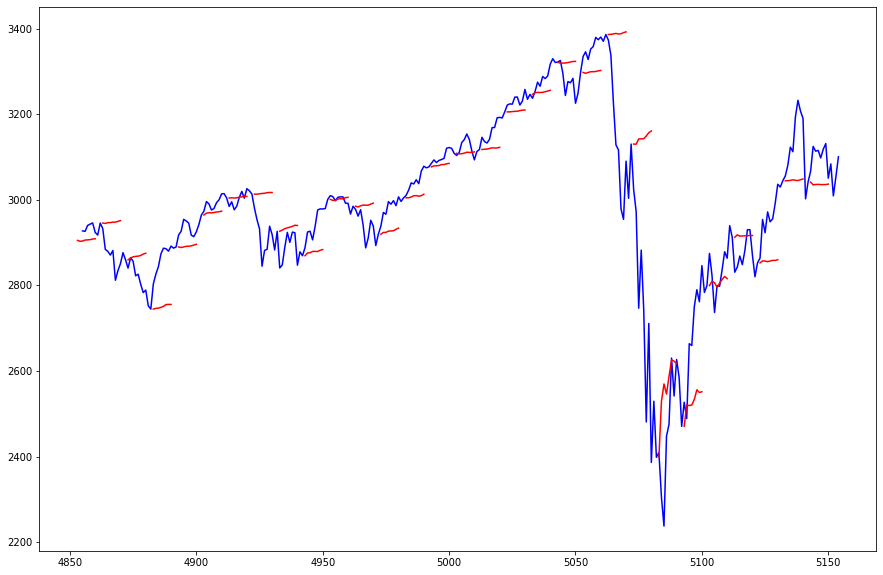

In [ ]:
#evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(pd.DataFrame(series['Close']), forecasts, n_test+2)

In [ ]:
new_ar = np.gradient(df['INT_RT'])*10

In [ ]:
new_ar

array([-0.63 ,  0.255,  0.32 , ..., -0.19 ,  0.085,  0.17 ])

In [ ]:
new_scaler = MinMaxScaler(feature_range=(-1, 1))
new_values = new_scaler.fit_transform(new_ar.reshape(-1,1))

In [ ]:
new_values

array([[-0.3761658 ],
       [-0.00932642],
       [ 0.01761658],
       ...,
       [-0.19378238],
       [-0.07979275],
       [-0.04455959]])